In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
#for roc and auc
from sklearn import metrics

#below needed to display decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
# from sklearn.metrics import mean_squared_error

import json
import requests
from bs4 import BeautifulSoup

#import my function files
import webscrape_wiki_table
import config
import query_helper
import time

#utilities file for timer
from utilities import *

### Clean mushroom data

In [3]:
hymeniumType =  ['gills'   
                ,'pores'
                ,'smooth'
                ,'ridges'
                ,'teeth'
                ,'gleba']

In [4]:
capShape =  ['campanulate'
            ,'conical'
            ,'convex'
            ,'depressed'
            ,'flat'
            ,'infundibuliform'
            ,'offset'
            ,'ovate'
            ,'umbilicate'
            ,'umbonate'
            ,'no'
            ,'NA']

In [5]:
whichGills = ['adnate'
            ,'adnexed'
            ,'decurrent'
            ,'emarginate'
            ,'free'
            ,'seceding'
            ,'sinuate'
            ,'subdecurrent'
            ,'no'
            ,'NA']

In [6]:
stipeCharacter = ['bare'
                ,'ring'
                ,'volva'
                ,'ring_and_volva'
                ,'cortina'
                ,'NA']

In [7]:
sporePrintColor = ['black'
                    ,'blackish-brown'
                    ,'brown'
                    ,'buff'
                    ,'cream'
                    ,'green'
                    ,'ochre'
                    ,'olive'
                    ,'olive-brown'
                    ,'pink'
                    ,'pinkish-brown'
                    ,'purple'
                    ,'purple-black'
                    ,'purple-brown'
                    ,'reddish-brown'
                    ,'salmon'
                    ,'tan'
                    ,'white'
                    ,'yellow'
                    ,'yellow-orange'
                    ,'yellow-brown']

In [8]:
ecologicalType =['mycorrhizal'
                ,'parasitic'
                ,'saprotrophic']

In [13]:
howEdible = ['choice'
            ,'edible'
            ,'inedible'
            ,'unpalatable'
            ,'caution'
            ,'psychoactive'
            ,'poisonous'
            ,'allergenic'
            ,'deadly'
            ,'unknown']

In [14]:
mushroom_features = [hymeniumType, capShape, whichGills, stipeCharacter, sporePrintColor, ecologicalType, howEdible]

In [15]:
query ='''SELECT * FROM mushroom.wiki_mush;)'''

In [19]:
df = query_helper.query_to_df(query)
df.to_csv('wiki_mush_db.csv')      #saves the file for use later without needing to connect to AWS db
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth hymenium,no distinct cap,hymenium attachment is irregular or not applic...,stipe is bare,spore print is olive-brown,ecology is saprotrophic,edibility: unknown
1,Agaricus abruptibulbus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible
2,Agaricus amicosus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: choice
3,Agaricus arvensis,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown\n to blackish-brown,ecology is saprotrophic,edibility: choice
4,Agaricus augustus,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible


## Take feature out of each string

In [20]:
#pull feature out of string **LIMITED TO FIRST MATCH CURRENTLY
def get_feature_type(feature, x):
    #clean string
    s = x.replace('\n', ' ') 
    s = s.split()
    
    #look at each word to find match
    for catagory in feature:
        if catagory in s:
            feat = catagory
            return feat
    return 'na'

In [21]:
for features, col in zip(mushroom_features, df.columns[1:]):
#     print(i)
    df[col] = df[col].apply(lambda x: get_feature_type(features, x))

In [23]:
df.whichGills.value_counts()

adnate          241
free            140
decurrent       113
adnexed          82
na               56
emarginate        5
seceding          2
subdecurrent      2
sinuate           1
Name: whichGills, dtype: int64

In [24]:
df.shape

(642, 8)

### Get genus from name

In [201]:
df['genus']= '0'
df['genus']= df['name'].apply(lambda x: (x.split()[0]) if len(x.split())==2 else x)

In [202]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,inedible,Lysurus
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible,Agaricus
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus


#### Drop erroroneous names

In [209]:
df[df['name']=='var.'].index

Int64Index([630], dtype='int64')

In [205]:
bool_list = [True if len(name.split())==1 else False for name in df.name]

In [207]:
df[bool_list]

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
91,Armillaria,gills,convex,adnate,ring,white,parasitic,edible,Armillaria
101,Blusher,gills,flat,free,ring,white,mycorrhizal,edible,Blusher
126,Caloscypha,na,no,na,na,white,saprotrophic,inedible,Caloscypha
130,Cantharellus,ridges,infundibuliform,decurrent,bare,yellow,mycorrhizal,edible,Cantharellus
193,Craterellus,ridges,infundibuliform,decurrent,bare,cream,saprotrophic,edible,Craterellus
209,Enokitake,gills,convex,adnexed,bare,white,saprotrophic,edible,Enokitake
217,Galerina,gills,convex,adnexed,bare,brown,saprotrophic,inedible,Galerina
368,Matsutake,gills,convex,adnexed,ring,white,mycorrhizal,edible,Matsutake
369,Melanoleuca,gills,convex,adnate,bare,cream,saprotrophic,edible,Melanoleuca
428,Mythicomyces,gills,conical,adnate,bare,purple-brown,saprotrophic,inedible,Mythicomyces


In [203]:
df[len(df['name'].split())==1]

AttributeError: 'Series' object has no attribute 'split'

## Filling NA Values

### Create table of most common feature for each genus

In [197]:
genus_popular_features = pd.DataFrame(columns=df.columns)
genus_popular_features.drop(columns='name',inplace=True)

In [198]:
genus_popular_features.head()

,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus


In [200]:
df.genus.unique()

array(['Lysurus', 'Agaricus', 'Agrocybe', 'Albatrellus', 'Aleuria',
       'Amanita', '0', 'Armillaria', 'Artomyces', 'Aseroe',
       'Aureoboletus', 'Auriscalpium', 'Baorangia', 'Boletellus',
       'Boletus', 'Bovista', 'Caloboletus', 'Calocera', 'Calocybe',
       'Caloscypha', 'Calvatia', 'Candy', 'Cantharellus', 'Catathelasma',
       'Cerioporus', 'Chlorophyllum', 'Clathrus', 'Clitocybe',
       'Clitopilus', 'Collybia', 'Conocybe', 'Coprinellus', 'Coprinopsis',
       'Coprinus', 'Cortinarius', 'Craterellus', 'Crepidotus',
       'Cyptotrama', 'Cystoderma', 'Cystodermella', 'Cystolepiota',
       'Daedalea', 'Daldinia', 'Deconica', 'Discina', 'Entoloma',
       'Exsudoporus', 'Fistulina', 'Fomitopsis', 'Galerina', 'Ganoderma',
       'Gliophorus', 'Gomphidius', 'Gomphus', 'Grifola', 'Gymnopilus',
       'Gymnopus', 'Gyromitra', 'Gyroporus', 'Handkea', 'Hebeloma',
       'Helvella', 'Heterobasidion', 'Humidicutis', 'Hydnellum', 'Hydnum',
       'Hygrocybe', 'Hygrophoropsis', 'Hy

In [199]:
pd.concat([pd.DataFrame([i], columns=['A']) for i in range(5)],
          ignore_index=True)

,A
0,0
1,1
2,2
3,3
4,4


In [187]:
df[df.genus=='Agaricus']

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible,Agaricus
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
5,Agaricus bernardii,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
6,Agaricus bisporus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
7,Agaricus bitorquis,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
8,Agaricus brunneofibrillosus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
9,Agaricus campestris,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
10,Agaricus deserticola,gills,convex,free,bare,purple-black,saprotrophic,edible,Agaricus


In [186]:
df[df.genus=='Lysurus']

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,inedible,Lysurus
362,Lysurus periphragmoides,smooth,flat,na,volva,olive-brown,saprotrophic,edible,Lysurus


## Feature Distributions

In [25]:
df.columns[1:]

Index(['hymeniumType', 'capShape', 'whichGills', 'stipeCharacter',
       'sporePrintColor', 'ecologicalType', 'howEdible'],
      dtype='object')

In [26]:
f'hello my nema {df.columns}'

"hello my nema Index(['name', 'hymeniumType', 'capShape', 'whichGills', 'stipeCharacter',\n       'sporePrintColor', 'ecologicalType', 'howEdible'],\n      dtype='object')"

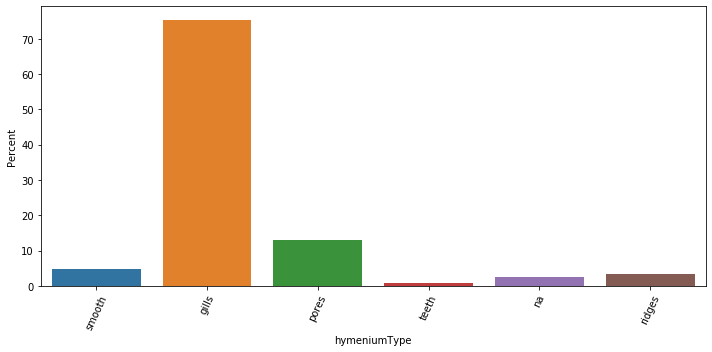

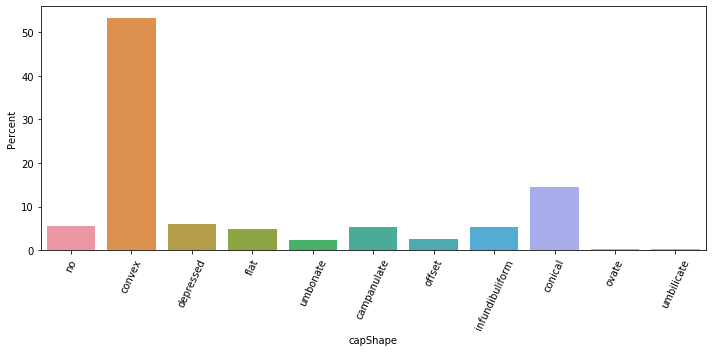

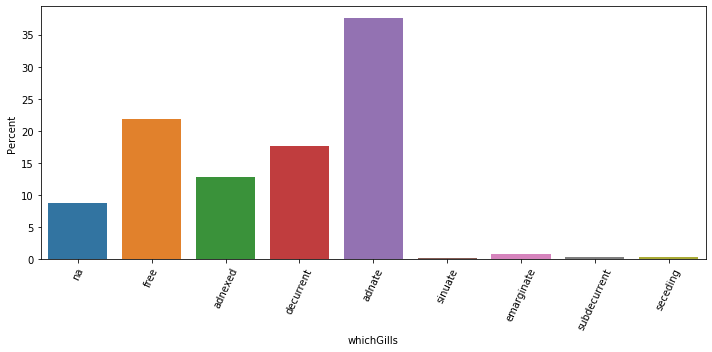

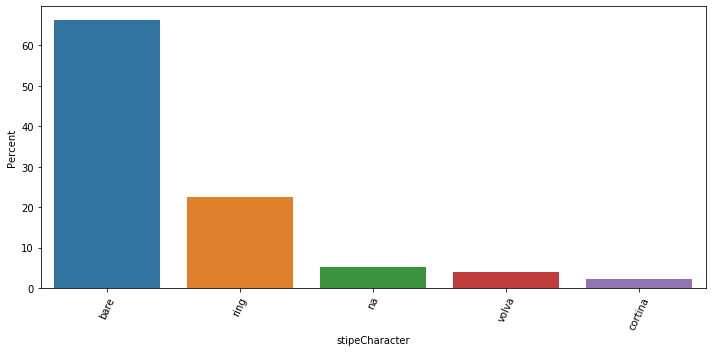

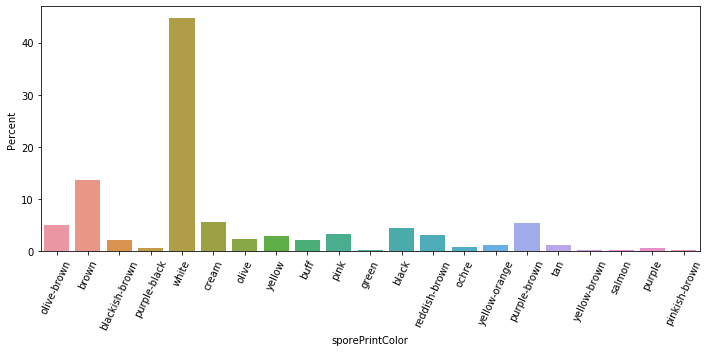

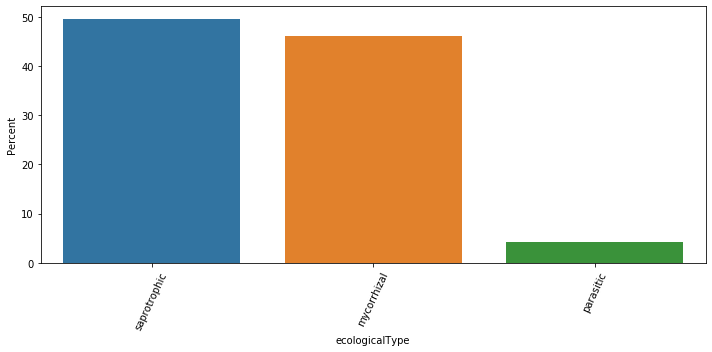

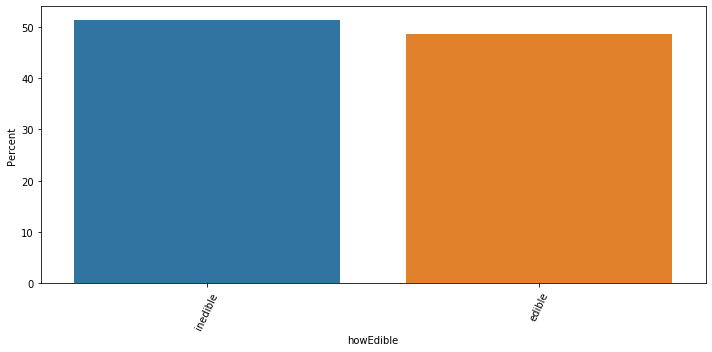

In [34]:
for col in df.columns[1:]:
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=col, y=col, data=df, orient="v", estimator=lambda x: len(x) / len(df) * 100)
    ax.set(ylabel="Percent")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
    plt.tight_layout()
#     plt.gcf().subplots_adjust(bottom=0.3)
    plt.savefig(f'graphs/{col}.png')

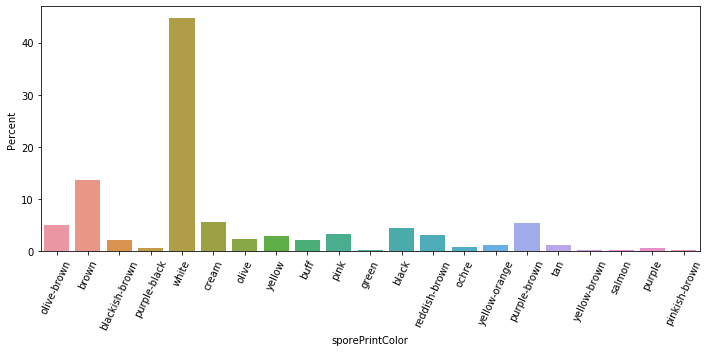

In [28]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x="sporePrintColor", y="sporePrintColor", data=df, orient="v", estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
plt.tight_layout()



In [30]:
# plt.figure(figsize=(10,5))
# ax = sns.barplot(x='hymeniumType', y='hymeniumType', data=df, orient="v", estimator=lambda x: len(x) / len(df) * 100)
# ax.set(ylabel="Percent")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

In [36]:
# plt.figure(figsize=(10,5))
# ax = sns.countplot(x="sporePrintColor", data=df)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

In [38]:
df.isin(['na']).sum()

name                0
hymeniumType       17
capShape            0
whichGills         56
stipeCharacter     33
sporePrintColor     0
ecologicalType      0
howEdible           0
dtype: int64

In [39]:
for col in df.columns[1:]:
    print(df[col].value_counts())

gills     484
pores      84
smooth     30
ridges     22
na         17
teeth       5
Name: hymeniumType, dtype: int64
convex             342
conical             93
depressed           38
no                  36
infundibuliform     34
campanulate         34
flat                31
offset              16
umbonate            15
ovate                2
umbilicate           1
Name: capShape, dtype: int64
adnate          241
free            140
decurrent       113
adnexed          82
na               56
emarginate        5
seceding          2
subdecurrent      2
sinuate           1
Name: whichGills, dtype: int64
bare       426
ring       144
na          33
volva       25
cortina     14
Name: stipeCharacter, dtype: int64
white             287
brown              87
cream              36
purple-brown       35
olive-brown        32
black              28
pink               21
reddish-brown      20
yellow             19
olive              15
buff               14
blackish-brown     14
yellow-orange   

In [40]:
#map edibiliy to binary groups
df.loc[:,'howEdible'] = df.howEdible.map(lambda x : {
    'edible'      : 'edible',
    'choice'      : 'edible',
    'psychoactive': 'edible',
    'inedible'    : 'inedible',
    'poisonous'   : 'inedible',
    'unknown'     : 'inedible',
    'deadly'      : 'inedible',
    'na'           : 'inedible',
    'unpalatable' : 'inedible'
}[x])

In [41]:
df.howEdible.value_counts()

inedible    330
edible      312
Name: howEdible, dtype: int64

In [42]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth,no,na,bare,olive-brown,saprotrophic,inedible
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible


In [43]:
df.describe()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
count,642,642,642,642,642,642,642,642
unique,642,6,11,9,5,21,3,2
top,Gymnopilus luteoviridis,gills,convex,adnate,bare,white,saprotrophic,inedible
freq,1,484,342,241,426,287,319,330


In [46]:
dfx=df.drop(columns=['name', 'howEdible'])
dfx.head()

,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,genus
0,smooth,no,na,bare,olive-brown,saprotrophic,Lysurus
1,gills,convex,free,ring,brown,saprotrophic,Agaricus
2,gills,convex,free,ring,brown,saprotrophic,Agaricus
3,gills,convex,free,ring,blackish-brown,saprotrophic,Agaricus
4,gills,convex,free,ring,brown,saprotrophic,Agaricus


# Further EDA 

#### Lets start by looking at target variable howEdible

Target Variable
howEdible
edible      312
inedible    330
Name: howEdible, dtype: int64


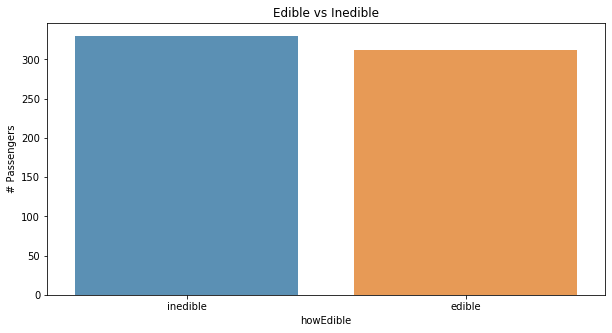

In [51]:
# edible Count
print('Target Variable')
print(df.groupby(['howEdible']).howEdible.count())

# Target Variable Countplot
# sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['howEdible'], alpha =.80)
plt.title('Edible vs Inedible')
plt.ylabel('# Passengers')
plt.show()

Now lets get a general feel for all of the variable counts

Text(0.5, 1.0, 'hymeniumType')

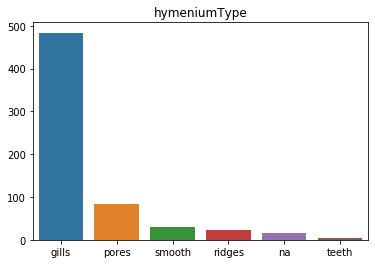

In [24]:
hc= dfx.hymeniumType.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('hymeniumType')

Text(0.5, 1.0, 'capShape')

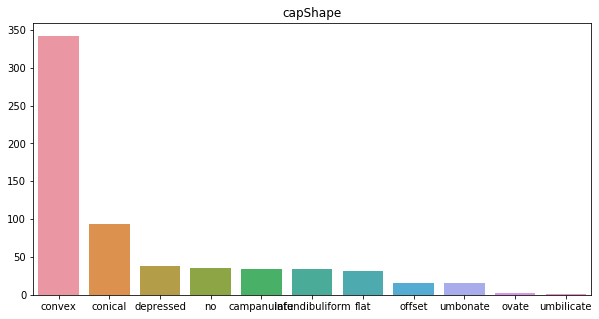

In [25]:
hc= dfx.capShape.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('capShape')

Text(0.5, 1.0, 'whichGills')

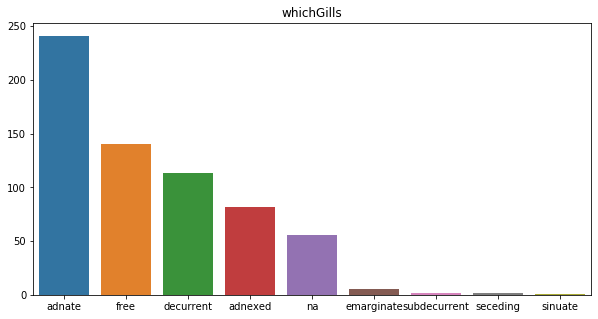

In [26]:
hc= dfx.whichGills.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('whichGills')

Text(0.5, 1.0, 'stipeCharacter')

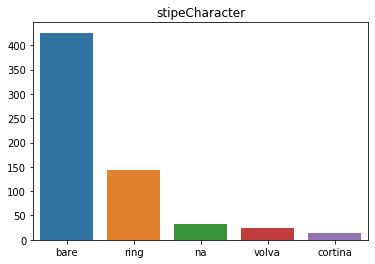

In [27]:
hc= dfx.stipeCharacter.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('stipeCharacter')

Text(0.5, 1.0, 'sporePrintColor')

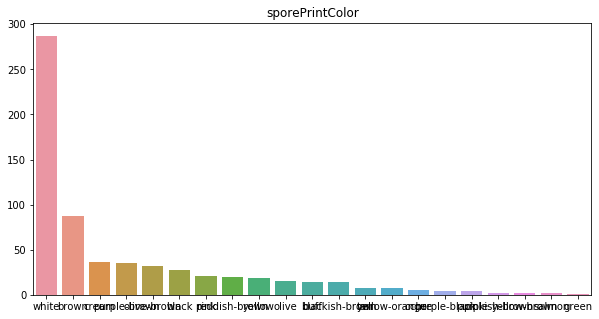

In [28]:
hc= dfx.sporePrintColor.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('sporePrintColor')

Text(0.5, 1.0, 'ecologicalType')

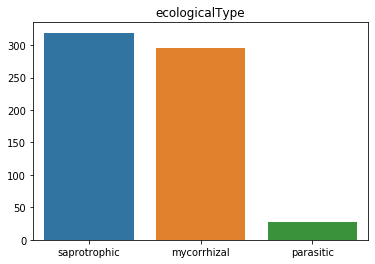

In [29]:
hc= dfx.ecologicalType.value_counts()
sns.barplot(hc.index, hc.values)
plt.title('ecologicalType')

Text(0.5, 1.0, 'genus')

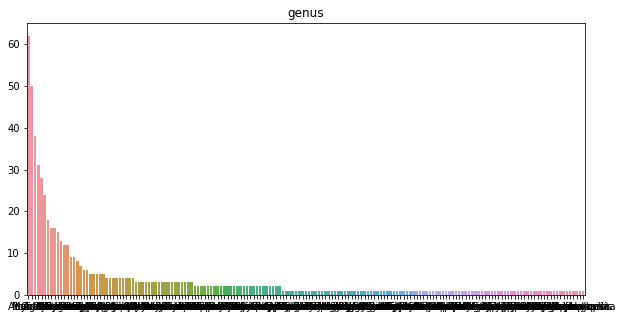

In [30]:
hc= dfx.genus.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(hc.index, hc.values)
plt.title('genus')

In [31]:
df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack()

howEdible,edible,inedible
hymeniumType,,
gills,217,267
na,8,9
pores,49,35
ridges,21,1
smooth,14,16
teeth,3,2


#### Now we'll look at if certain features determine edibility 

howEdible     edible  inedible
hymeniumType                  
gills            217       267
na                 8         9
pores             49        35
ridges            21         1
smooth            14        16
teeth              3         2


<Figure size 720x360 with 0 Axes>

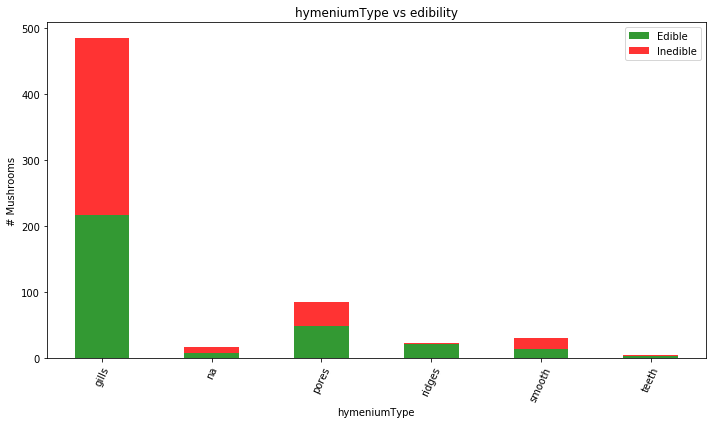

howEdible        edible  inedible
capShape                         
campanulate        13.0      21.0
conical            33.0      60.0
convex            183.0     159.0
depressed          15.0      23.0
flat               17.0      14.0
infundibuliform    23.0      11.0
no                 14.0      22.0
offset              7.0       9.0
ovate               1.0       1.0
umbilicate          NaN       1.0
umbonate            6.0       9.0


<Figure size 720x360 with 0 Axes>

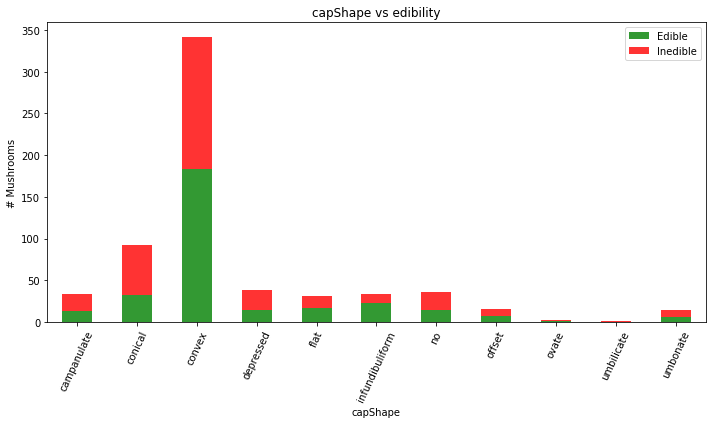

howEdible     edible  inedible
whichGills                    
adnate         116.0     125.0
adnexed         36.0      46.0
decurrent       62.0      51.0
emarginate       4.0       1.0
free            63.0      77.0
na              30.0      26.0
seceding         NaN       2.0
sinuate          1.0       NaN
subdecurrent     NaN       2.0


<Figure size 720x360 with 0 Axes>

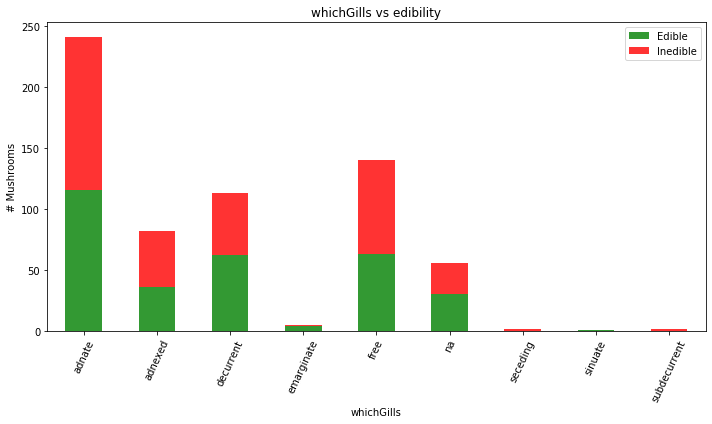

howEdible       edible  inedible
stipeCharacter                  
bare               212       214
cortina              2        12
na                  16        17
ring                72        72
volva               10        15


<Figure size 720x360 with 0 Axes>

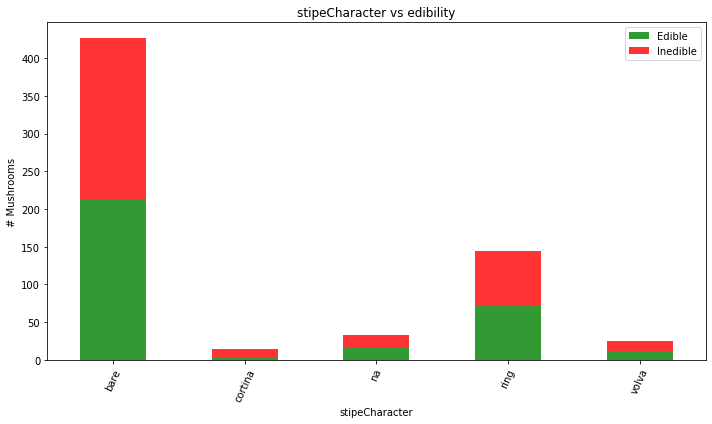

howEdible        edible  inedible
sporePrintColor                  
black              18.0      10.0
blackish-brown     10.0       4.0
brown              46.0      41.0
buff                7.0       7.0
cream              22.0      14.0
green               NaN       1.0
ochre               3.0       2.0
olive              11.0       4.0
olive-brown        18.0      14.0
pink               13.0       8.0
pinkish-brown       NaN       2.0
purple              4.0       NaN
purple-black        2.0       2.0
purple-brown       28.0       7.0
reddish-brown       5.0      15.0
salmon              2.0       NaN
tan                 6.0       1.0
white             101.0     186.0
yellow              9.0      10.0
yellow-brown        NaN       2.0
yellow-orange       7.0       NaN


<Figure size 720x360 with 0 Axes>

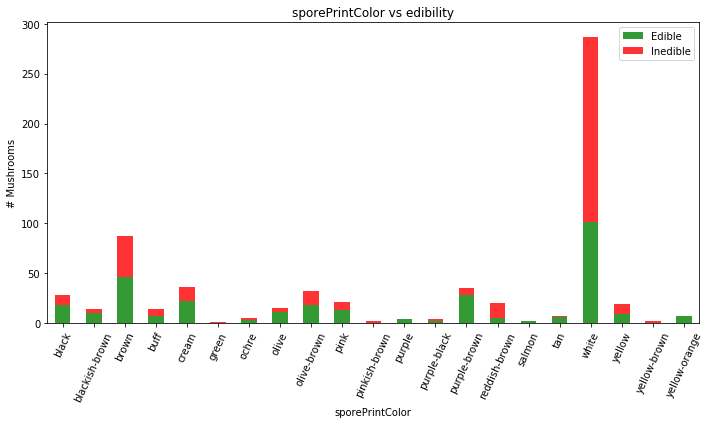

howEdible       edible  inedible
ecologicalType                  
mycorrhizal        148       148
parasitic           16        11
saprotrophic       148       171


<Figure size 720x360 with 0 Axes>

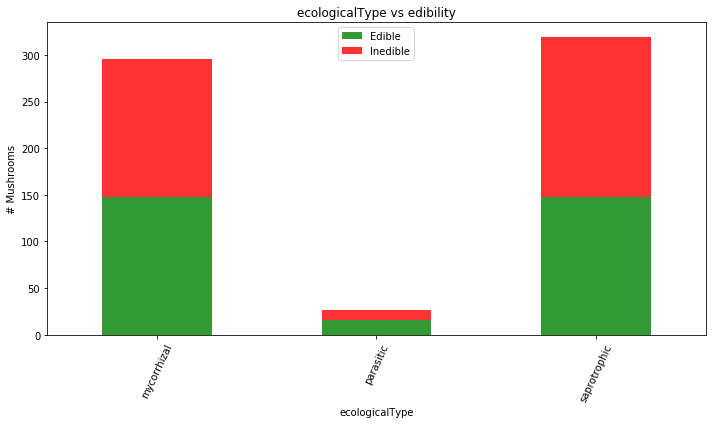

howEdible  edible  inedible
howEdible                  
edible      312.0       NaN
inedible      NaN     330.0


<Figure size 720x360 with 0 Axes>

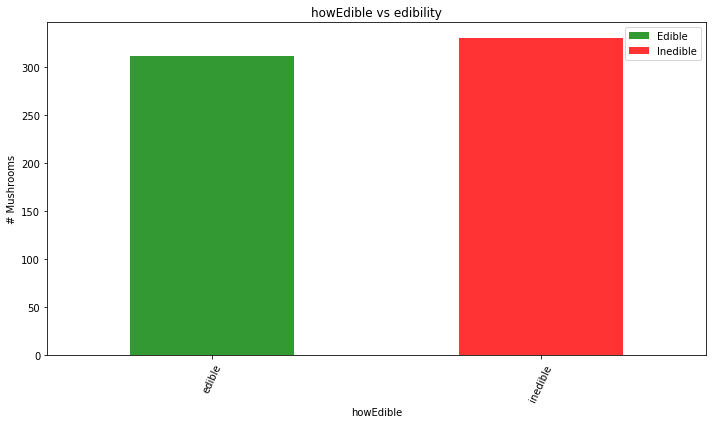

howEdible     edible  inedible
genus                         
0               18.0      10.0
Agaricus        19.0       5.0
Agrocybe         1.0       NaN
Albatrellus      NaN       1.0
Aleuria          1.0       NaN
...              ...       ...
Verpa            1.0       NaN
Volvariella      2.0       1.0
Volvopluteus     1.0       3.0
Xerocomellus     1.0       NaN
Xerula           NaN       1.0

[171 rows x 2 columns]


<Figure size 720x360 with 0 Axes>

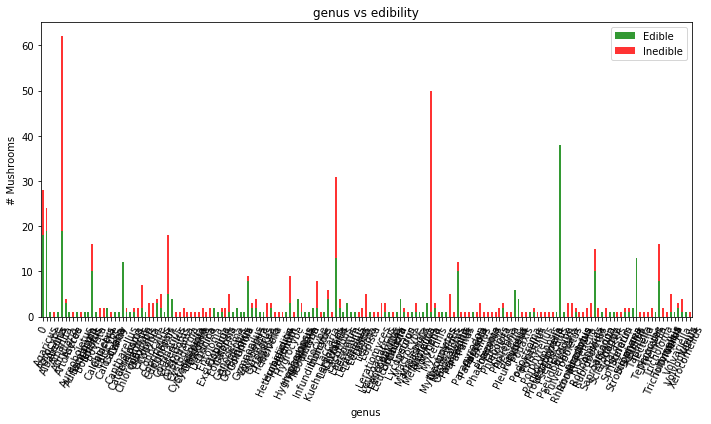

In [81]:
for col in df.columns[1:]:
    plt.figure(figsize=(10,5))
    f'{col} vs edibility\n'

    print(df.groupby([col,'howEdible'])[col].count().unstack())

    # feature edibility visualization
    groupby_feature = df.groupby([col,'howEdible'])[col].count().unstack()
    p1 = groupby_feature.plot(kind = 'bar', stacked = True, 
                       title = f'{col} vs edibility', 
                       color = ['green','red'], alpha = .8, figsize=(10,6))
    p1.set_xlabel(col)
    p1.set_xticklabels(p1.get_xticklabels(), rotation=65)
    p1.set_ylabel('# Mushrooms')
    p1.legend(['Edible','Inedible'])
    plt.tight_layout()
    plt.savefig(f'graphs/{col}_edibility_dist.png')
    plt.show()

hymeniumType vs edibility


howEdible     edible  inedible
hymeniumType                  
gills            217       267
na                 8         9
pores             49        35
ridges            21         1
smooth            14        16
teeth              3         2


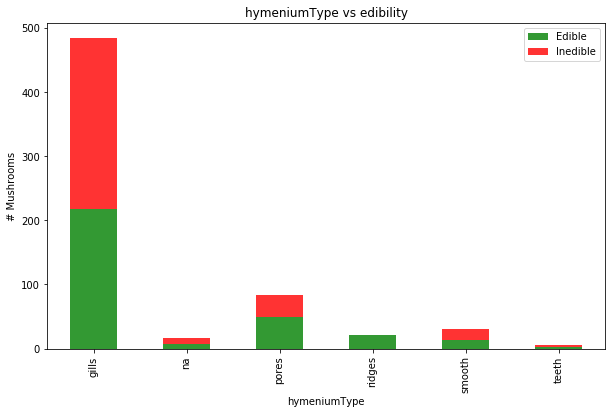

In [73]:

# #feature edibility visualization
# print('hymeniumType vs edibility')

# print('\n')
# print(df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack())

# # Passenger class visualization
# hymeniumType = df.groupby(['hymeniumType','howEdible']).hymeniumType.count().unstack()
# p1 = hymeniumType.plot(kind = 'bar', stacked = True, 
#                    title = 'hymeniumType vs edibility', 
#                    color = ['green','red'], alpha = .8, figsize=(10,6))
# p1.set_xlabel('hymeniumType')
# p1.set_ylabel('# Mushrooms')
# p1.legend(['Edible','Inedible'])
# plt.show()

Looks like ridges is only hymeniumType predictor that gives strong indication

#### Functions for models

In [82]:
import itertools
from sklearn.metrics import confusion_matrix
#confusion matrix to be used later
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

divide data into x and y and training set and get dummies

#### Prepare feature and target variables

In [176]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
y=y.map({'edible': 1, 'inedible': 0})
data.head()

,hymeniumType_gills,hymeniumType_na,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,sporePrintColor_reddish-brown,sporePrintColor_salmon,sporePrintColor_tan,sporePrintColor_white,sporePrintColor_yellow,sporePrintColor_yellow-brown,sporePrintColor_yellow-orange,ecologicalType_mycorrhizal,ecologicalType_parasitic,ecologicalType_saprotrophic
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [177]:
#break up data for testing and training
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=.2)
print(len(data_train), len(data_test))

513 129


# ML Models

## Split data into train test groups

In [ ]:
#done above

## Regular Tree

In [178]:
#function used to plot feature importance
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(40,40))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [179]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=30,random_state=1) 
tree_clf.fit(data_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

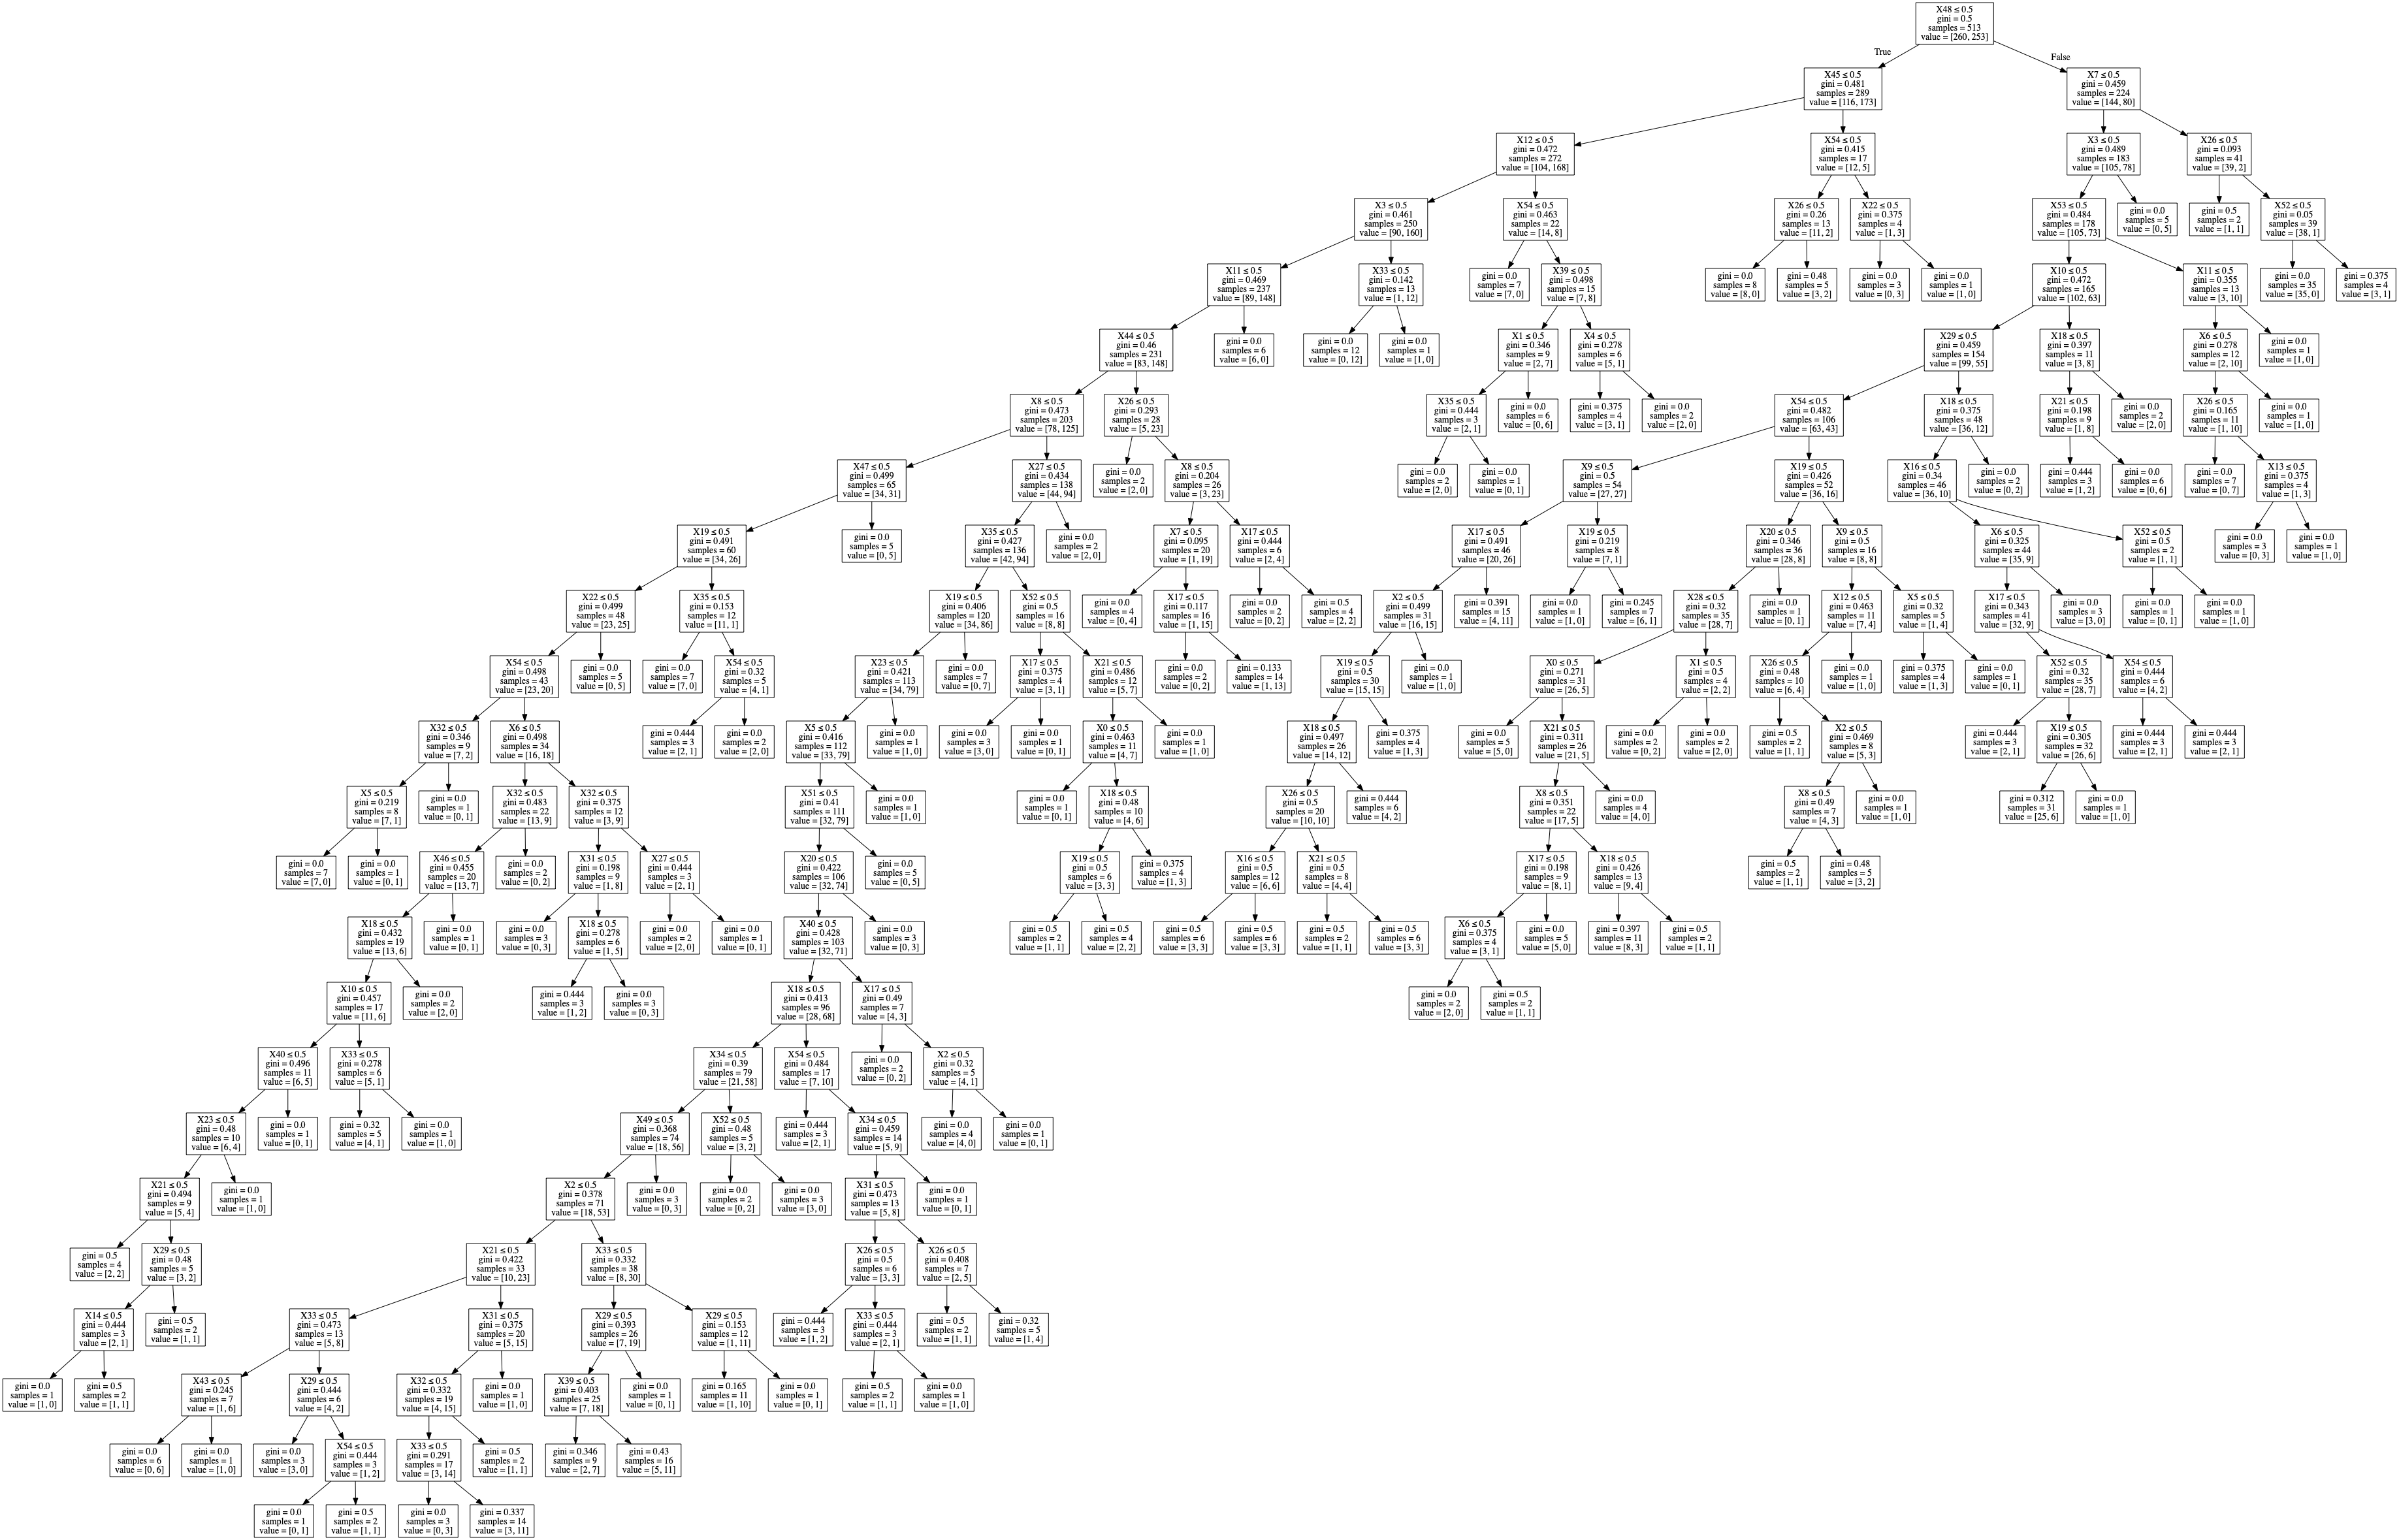

In [180]:
# visualizing the regression tree
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

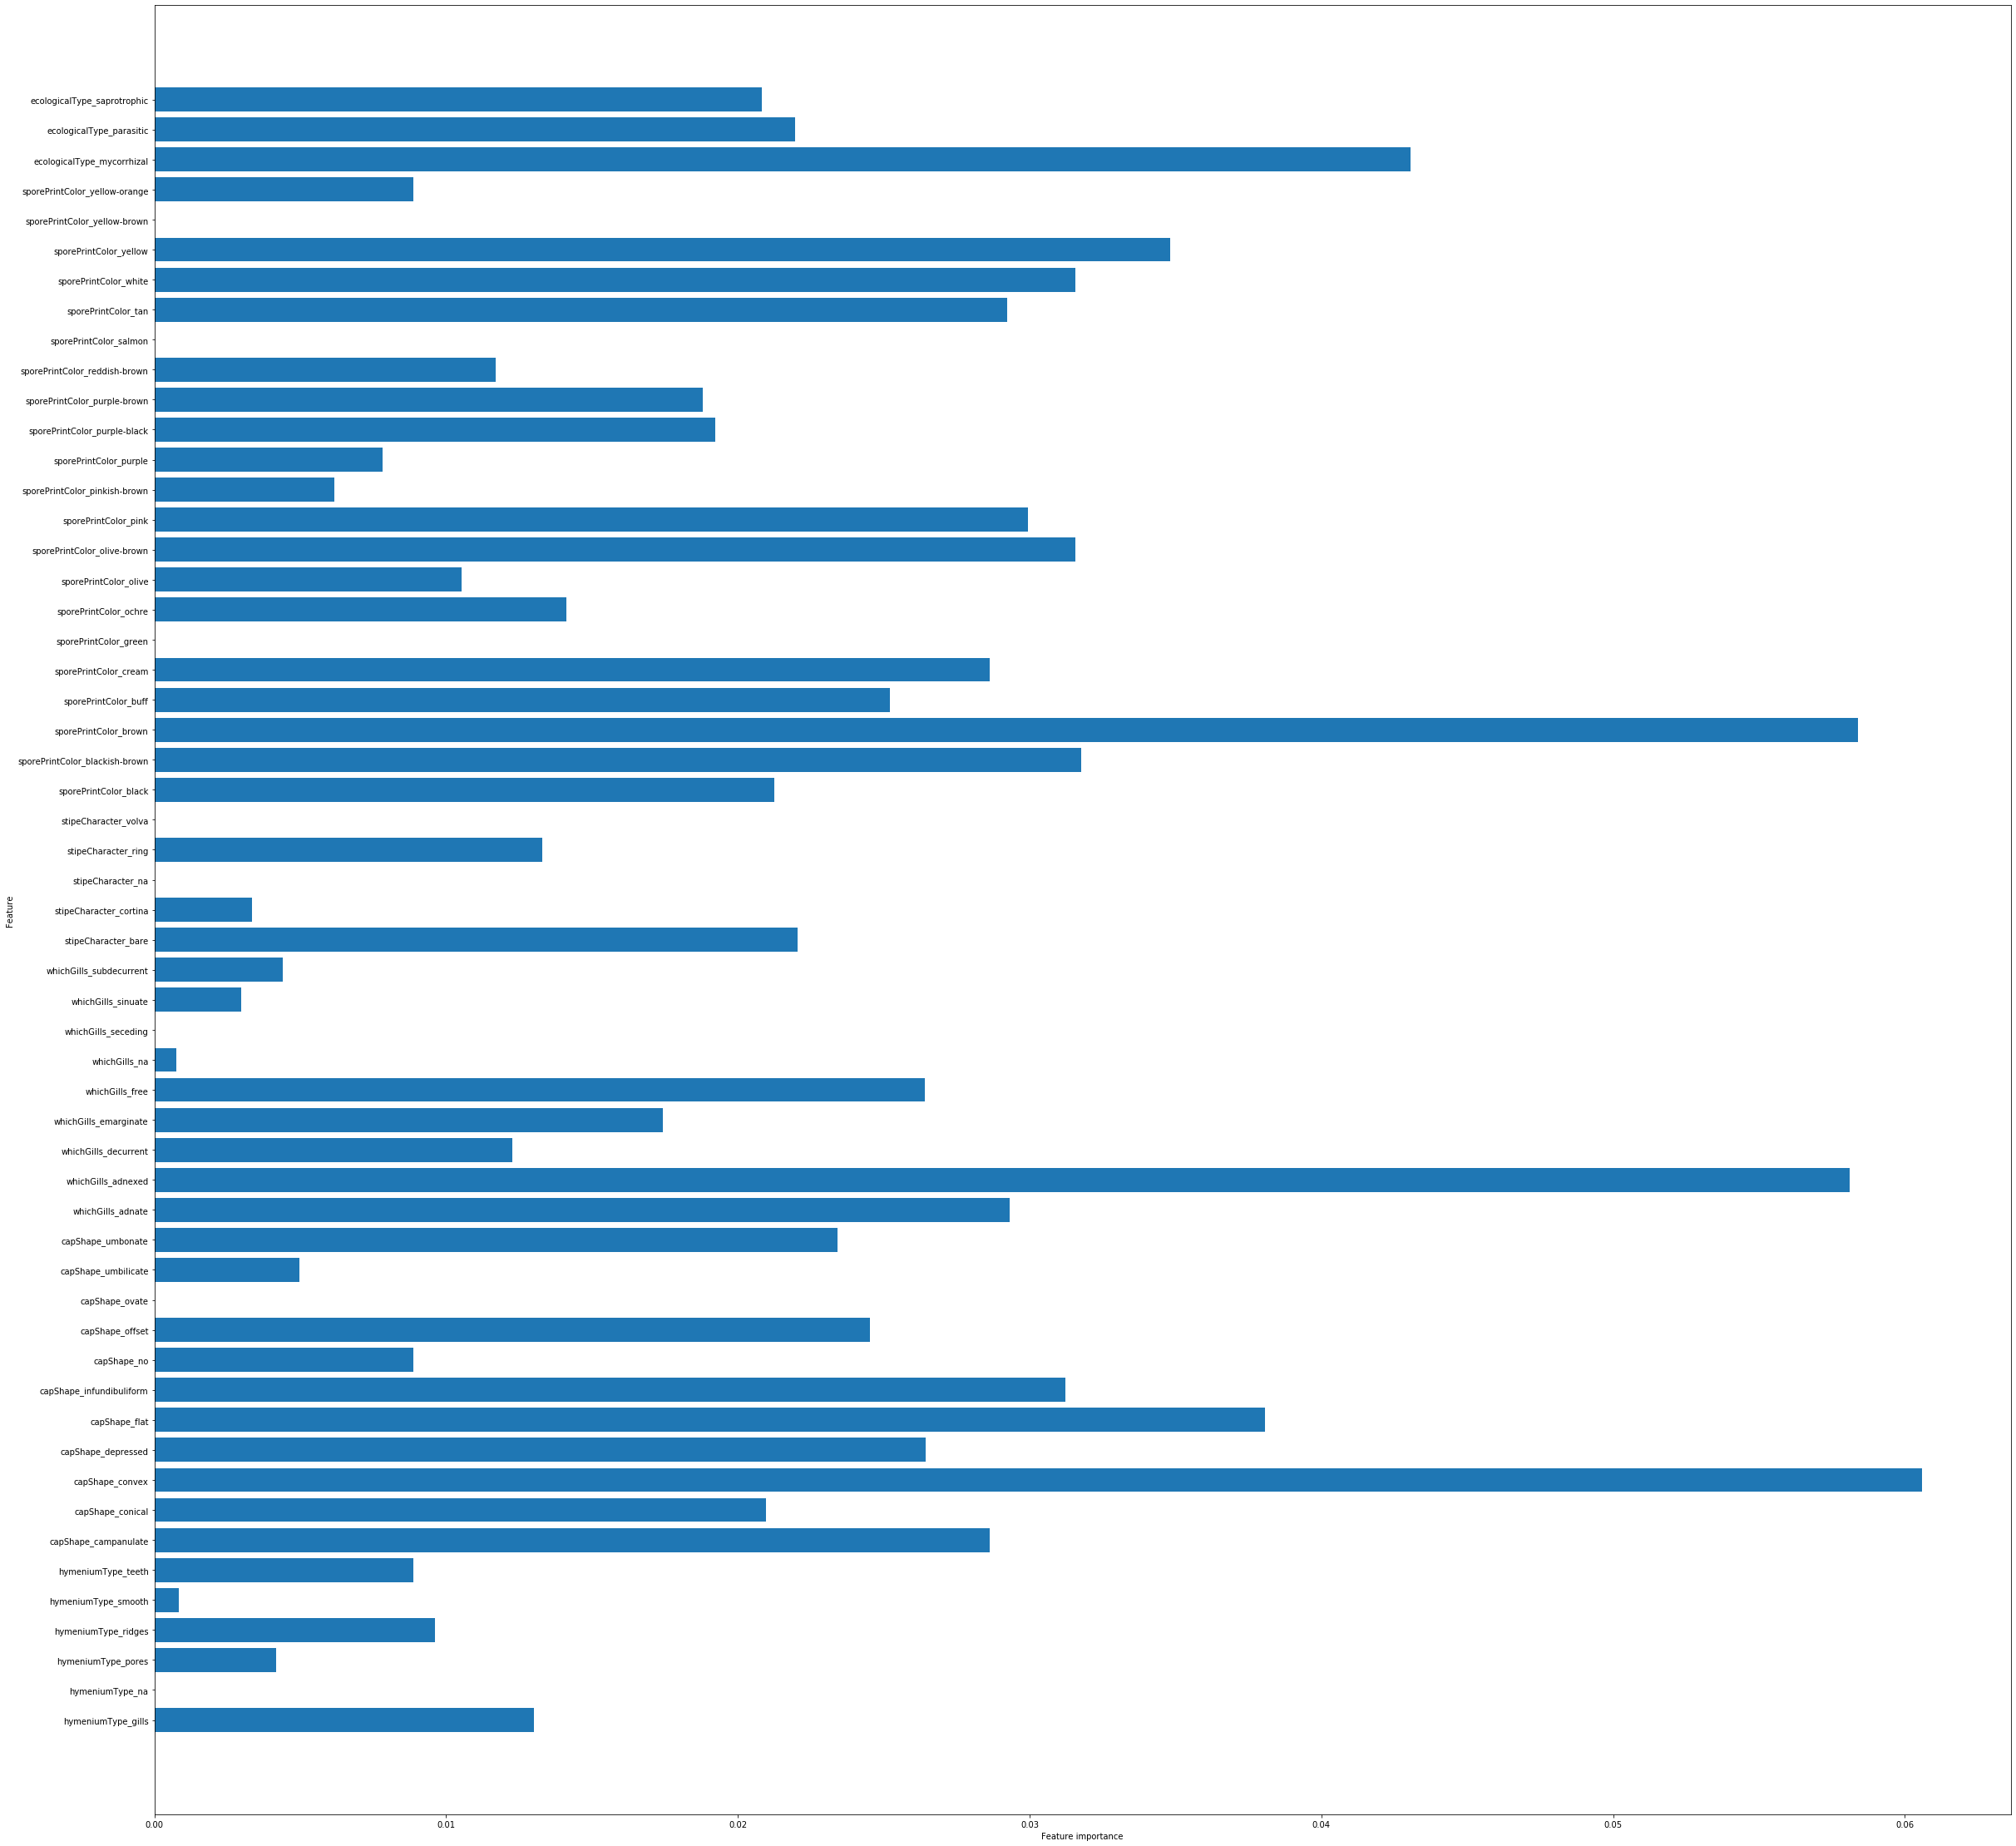

In [171]:
plot_feature_importances(tree_clf)

In [181]:
# Test set predictions
pred = tree_clf.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[52 18]
 [25 34]]
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        70
           1       0.65      0.58      0.61        59

    accuracy                           0.67       129
   macro avg       0.66      0.66      0.66       129
weighted avg       0.67      0.67      0.66       129



In [182]:
cm = confusion_matrix(y_test, pred)
classes = ['Edible', 'Inedible']

# cm = confusion_matrix(y_test,y_pred_class)
# classes = ['Perished', 'Survived']

Confusion Matrix, without normalization
[[52 18]
 [25 34]]


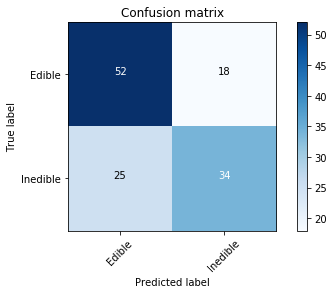

In [183]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [184]:
# Training accuracy score
tree_clf.score(data_train, y_train)

0.8538011695906432

In [185]:
# Test accuracy score
tree_clf.score(data_test, y_test)

0.6666666666666666

## Random Forest

### Random forest call

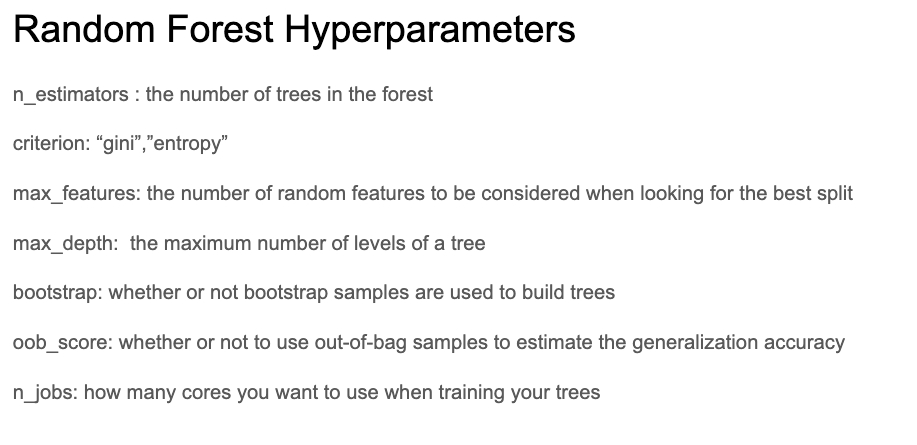

In [165]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100,random_state=10)
forest.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [166]:
# Forest with genus
predrf = forest.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, predrf))
print(classification_report(y_test, predrf))

[[37 26]
 [38 28]]
              precision    recall  f1-score   support

           0       0.49      0.59      0.54        63
           1       0.52      0.42      0.47        66

    accuracy                           0.50       129
   macro avg       0.51      0.51      0.50       129
weighted avg       0.51      0.50      0.50       129



Confusion Matrix, without normalization
[[37 26]
 [38 28]]


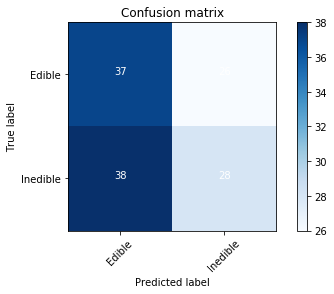

In [167]:
cm = confusion_matrix(y_test, predrf)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [168]:
# Training accuracy score
forest.score(data_train, y_train)

0.7641325536062378

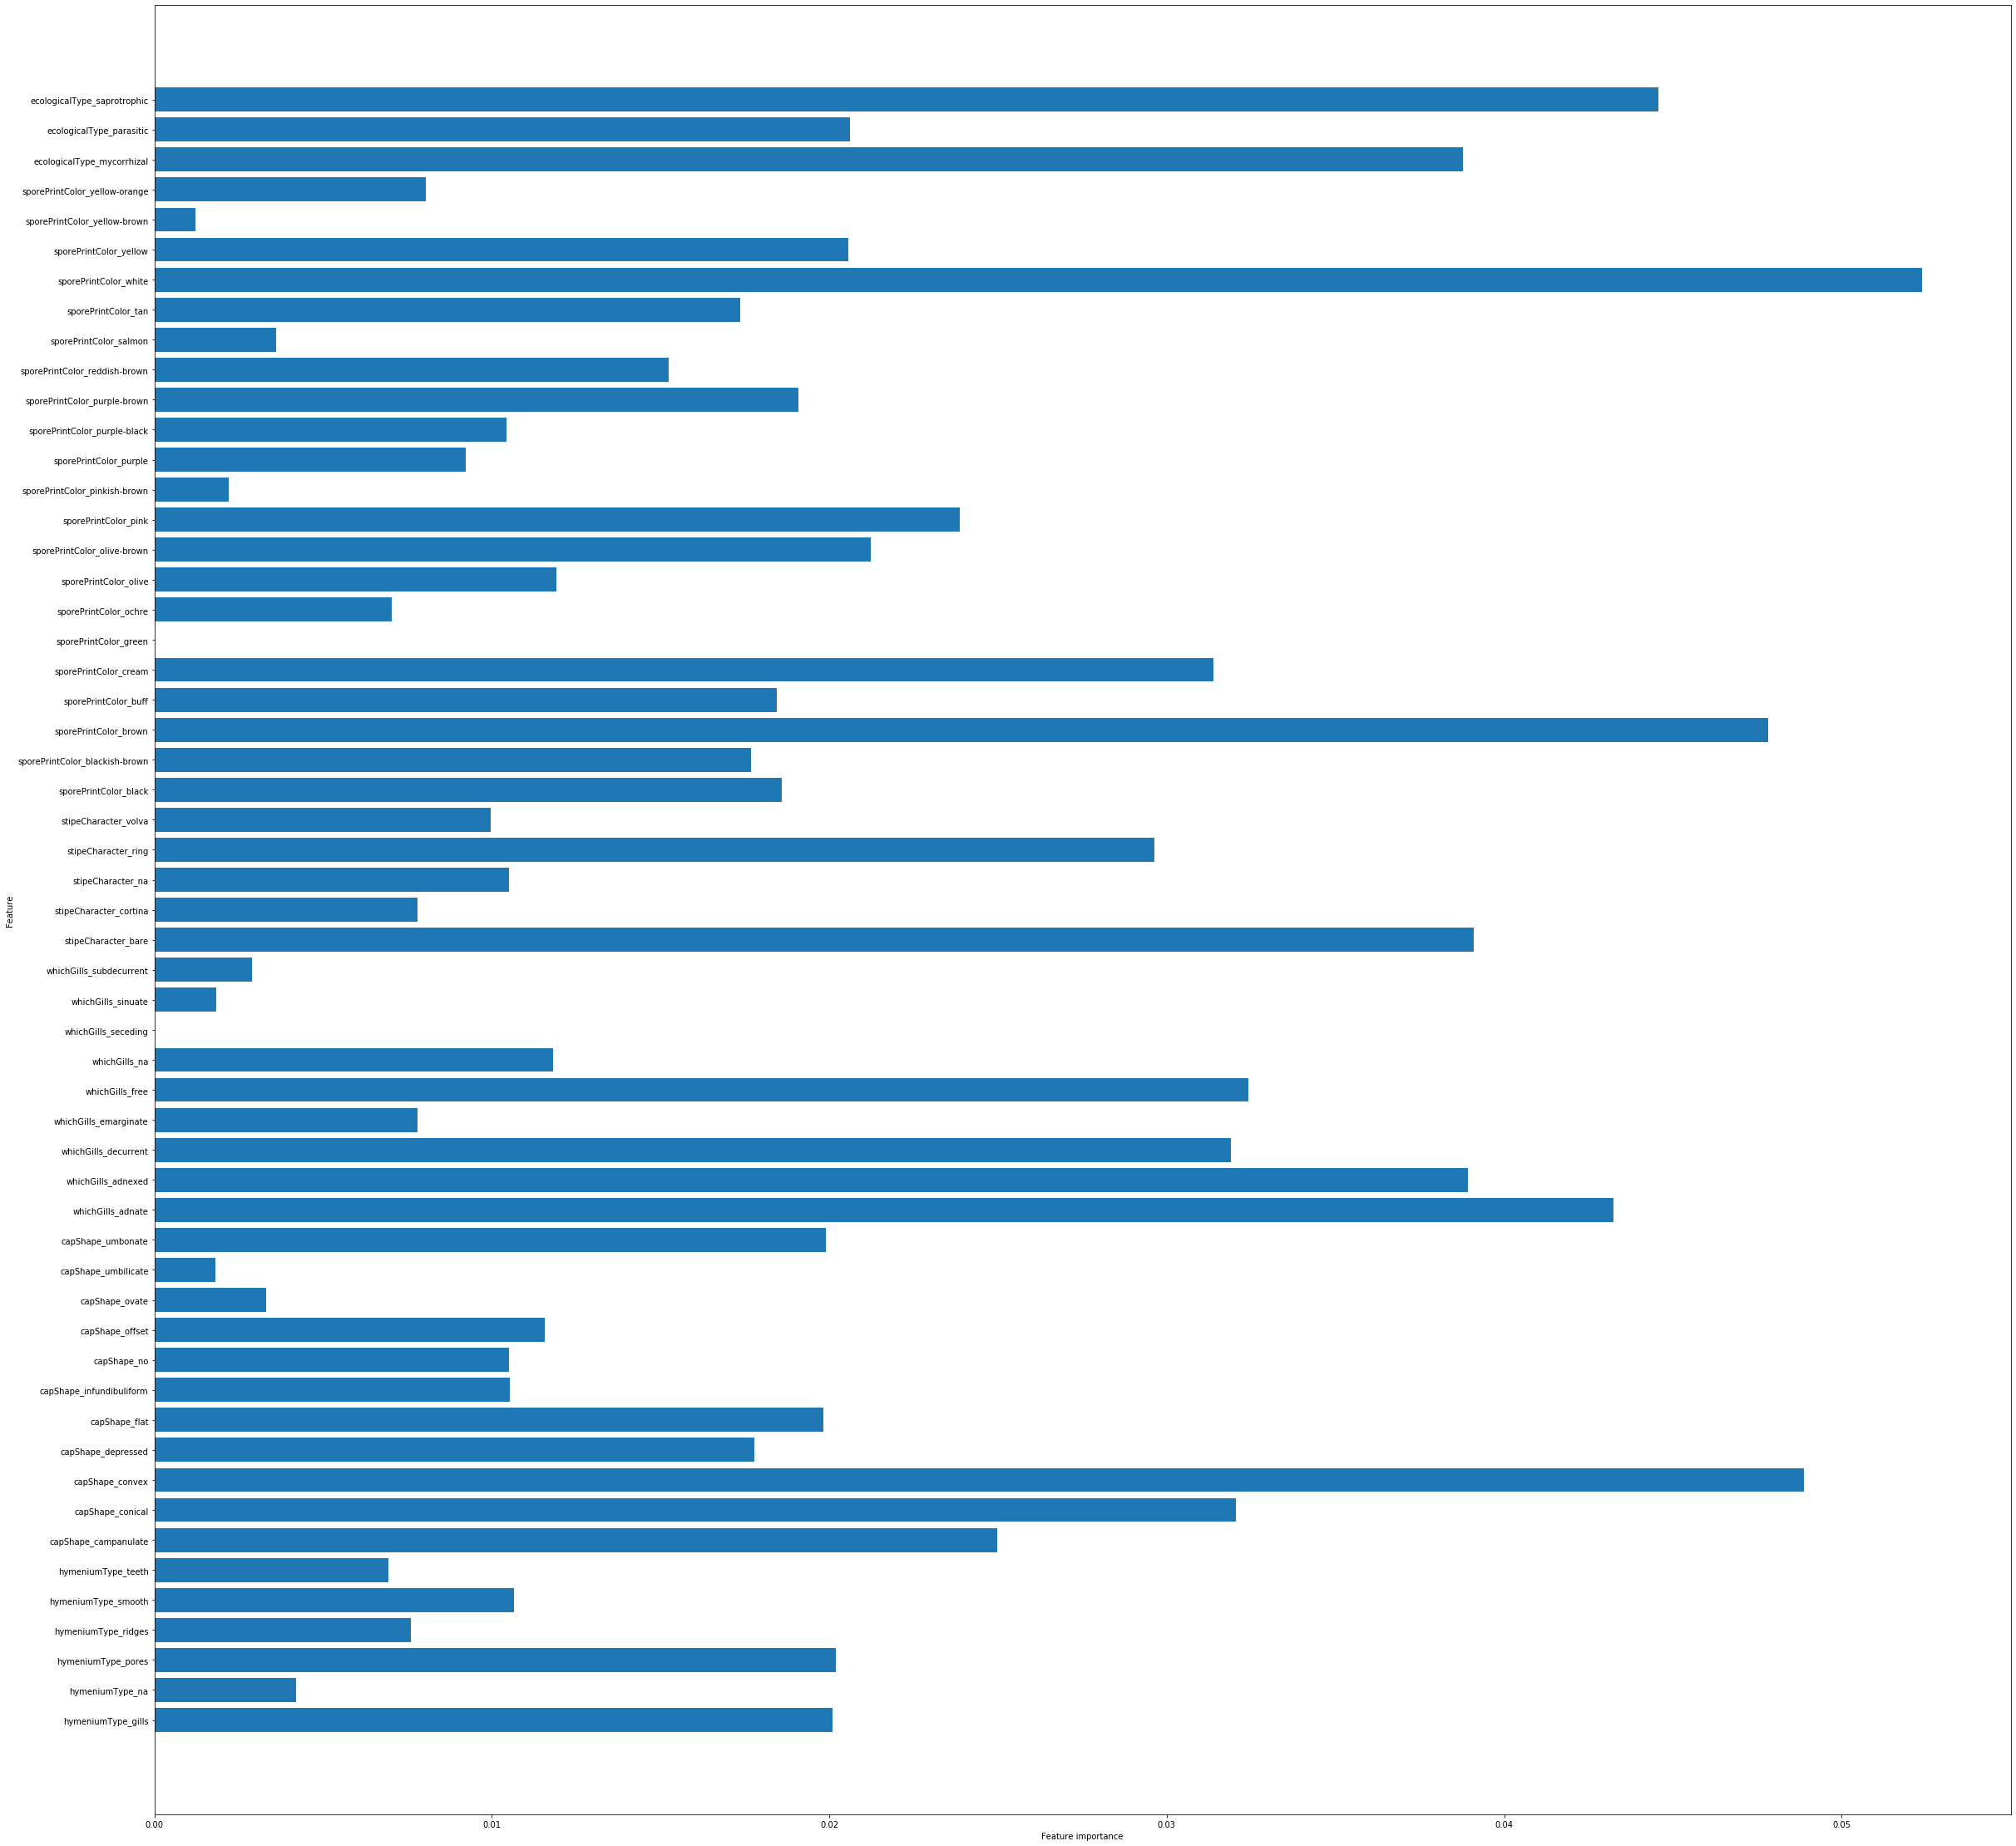

In [143]:
plot_feature_importances(forest)

In [169]:
# Test accuracy score
forest.score(data_test, y_test)

0.5038759689922481

### Now get ROC for Random Forest (currently under repair)

In [160]:
predrf

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0])

In [164]:
np.array(y_test)

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0])

In [166]:
fpr

array([0.        , 0.28767123, 1.        ])

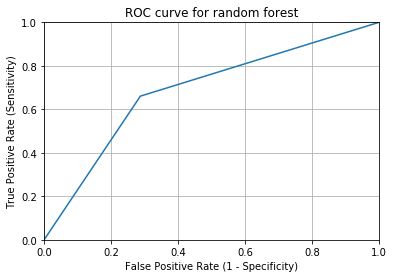

In [165]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, predrf)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for random forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

## Logistic Regression

In [103]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
y=y.map({'edible': 1, 'inedible': 0})
#break up data for testing and training
X_train, X_test, y_train, y_test = train_test_split(data, y,test_size=.2)
data.head()

,hymeniumType_gills,hymeniumType_na,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,sporePrintColor_reddish-brown,sporePrintColor_salmon,sporePrintColor_tan,sporePrintColor_white,sporePrintColor_yellow,sporePrintColor_yellow-brown,sporePrintColor_yellow-orange,ecologicalType_mycorrhizal,ecologicalType_parasitic,ecologicalType_saprotrophic
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [104]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
#idk if this works for classification
dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))
dictionary

{'hymeniumType_gills': -0.5215287126546837,
 'hymeniumType_na': -0.2559531208444509,
 'hymeniumType_pores': -0.5768375117007968,
 'hymeniumType_ridges': 1.900737411717202,
 'hymeniumType_smooth': -0.5415459600463055,
 'hymeniumType_teeth': -0.004634407170455606,
 'capShape_campanulate': -0.2285088916164167,
 'capShape_conical': -0.07195411072342503,
 'capShape_convex': 0.7300004732288511,
 'capShape_depressed': -0.3820036494471974,
 'capShape_flat': 0.5044103468591815,
 'capShape_infundibuliform': 0.10122751508310587,
 'capShape_no': -0.6179858537805715,
 'capShape_offset': -0.22168731518253734,
 'capShape_ovate': -0.1047996667729523,
 'capShape_umbilicate': -0.4152626221872806,
 'capShape_umbonate': 0.7068014738397591,
 'whichGills_adnate': -0.12633263051284196,
 'whichGills_adnexed': -0.2322126602874407,
 'whichGills_decurrent': 0.25469665078867354,
 'whichGills_emarginate': 0.3444806189442068,
 'whichGills_free': 0.09117088415259139,
 'whichGills_na': 0.35153860715949564,
 'whichGil

In [106]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

In [107]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6434108527131783


In [35]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class))

[[50  9]
 [28 42]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73        59
           1       0.82      0.60      0.69        70

    accuracy                           0.71       129
   macro avg       0.73      0.72      0.71       129
weighted avg       0.74      0.71      0.71       129



In [36]:
cm = confusion_matrix(y_test, y_pred_class)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

NameError: name 'plot_confusion_matrix' is not defined

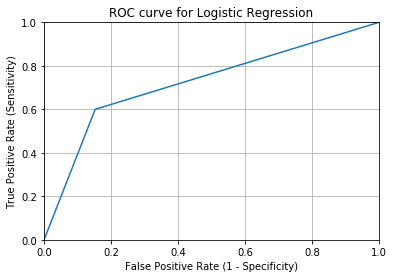

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_class)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [178]:
y_pred_class

array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0])

## Reassign features and Target Variables

In [60]:
# data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
# y = df['howEdible']
# #break up data for testing and training
# data_train, data_test, y_train, y_test = train_test_split(data, y,test_size=.2)
# data.head()

,hymeniumType_gills,hymeniumType_na,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,sporePrintColor_reddish-brown,sporePrintColor_salmon,sporePrintColor_tan,sporePrintColor_white,sporePrintColor_yellow,sporePrintColor_yellow-brown,sporePrintColor_yellow-orange,ecologicalType_mycorrhizal,ecologicalType_parasitic,ecologicalType_saprotrophic
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Use XGBoost on df without genus

In [108]:
from xgboost import XGBClassifier

In [113]:
# Instantiate XGBClassifier
clf = XGBClassifier(n_estimators=1000,random_state=1)

In [114]:
# Fit XGBClassifier
clf.fit(data_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [115]:
# Predict on training and test sets
training_preds_XG = clf.predict(data_train)
test_preds_XG = clf.predict(data_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds_XG)
test_accuracy = accuracy_score(y_test, test_preds_XG)

In [116]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 73.88%
Validation accuracy: 51.16%


In [117]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, test_preds_XG))
print(classification_report(y_test, test_preds_XG))

[[37 26]
 [37 29]]
              precision    recall  f1-score   support

           0       0.50      0.59      0.54        63
           1       0.53      0.44      0.48        66

    accuracy                           0.51       129
   macro avg       0.51      0.51      0.51       129
weighted avg       0.51      0.51      0.51       129



Confusion Matrix, without normalization
[[37 26]
 [37 29]]


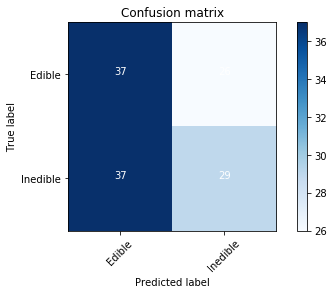

In [118]:
cm = confusion_matrix(y_test, test_preds_XG)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [119]:
clf.score(data_train, y_train)

0.7387914230019493

In [120]:
# Test accuracy score
clf.score(data_test, y_test)

0.5116279069767442

## Gridsearch CV


In [122]:
from sklearn.model_selection import GridSearchCV
#tuning process
param_grid = {
    'learning_rate': [0.1, ],
    'max_depth': [8,10,12],
    'min_child_weight': [1],
    'subsample': [0.5,.7],
    'n_estimators': [500,2000],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(data_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(data_train)
test_preds = grid_clf.predict(data_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 8
min_child_weight: 1
n_estimators: 500
subsample: 0.7


In [123]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 76.22%
Validation accuracy: 48.84%


Confusion Matrix, without normalization
[[33 30]
 [36 30]]


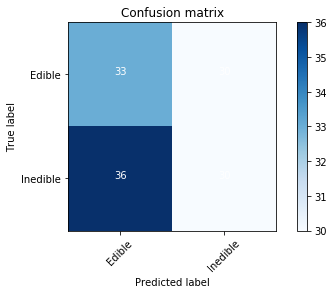

In [124]:
cm = confusion_matrix(y_test, test_preds)
classes = ['Edible', 'Inedible']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Look at AUC and ROC curves